# **Modelling**

# Check for GPU

In [1]:
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU is ready to be used

# Load Data

In [2]:
source = '../data/Rice_Leaf_AUG/Rice_Leaf_AUG'
train_dir = '../data/train'
val_dir = '../data/val'
test_dir = '../data/test'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    source,
    validation_split=0,
    label_mode = 'int',
    seed=0,
    batch_size=None

)

Found 11790 files belonging to 9 classes.


# Get Class Names

In [4]:
class_names = dataset.class_names
print(f'Class names: {class_names}')

Class names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight']


# Data Preprocessing

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # For EfficientNet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
train_ds = train_datagen.flow_from_directory(train_dir, 
    class_mode='sparse',
    target_size = (256, 256))

val_ds = val_datagen.flow_from_directory(val_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False)

test_ds = test_datagen.flow_from_directory(test_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False)

Found 9544 images belonging to 9 classes.
Found 1064 images belonging to 9 classes.
Found 1182 images belonging to 9 classes.


# Model Creation

## Define model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output_layer = Dense(9, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

## Train model

In [8]:
history = model.fit(train_ds, batch_size = 32, epochs=10, validation_data=val_ds)

Epoch 1/10
299/299 [==============================] - 92s 277ms/step - loss: 0.9427 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.5641 - val_sparse_categorical_accuracy: 0.8261
Epoch 2/10
299/299 [==============================] - 84s 281ms/step - loss: 0.5054 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.3951 - val_sparse_categorical_accuracy: 0.8665
Epoch 3/10
299/299 [==============================] - 85s 285ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.9004
Epoch 4/10
299/299 [==============================] - 86s 288ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9192
Epoch 5/10
299/299 [==============================] - 86s 286ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.2476 - val_sparse_categorical_accuracy: 0.9182
Epoch 6/10
299/299 [==============================] - 84s 281ms/step - loss: 0.1938 -

## Create loss plot

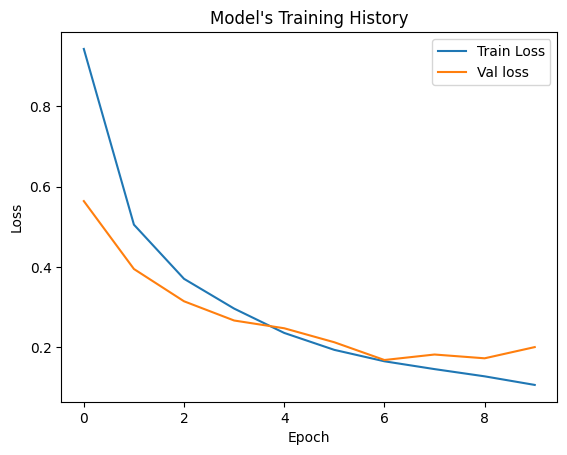

In [9]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Val loss')
plt.title('Model\'s Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict

In [10]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

37/37 [==============================] - 13s 309ms/step


array([4, 0, 0, ..., 8, 8, 8], dtype=int64)

In [11]:
model.evaluate(test_ds)

37/37 [==============================] - 11s 286ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9357


[0.20071257650852203, 0.9357022047042847]

## Evaluation

In [12]:
from sklearn.metrics import classification_report

print(classification_report(test_ds.labels, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.95      0.91      0.93       120
            Brown Spot       0.98      0.86      0.92       155
     Healthy Rice Leaf       0.99      1.00      1.00       109
            Leaf Blast       0.91      0.90      0.90       175
            Leaf scald       0.97      0.88      0.92       134
Narrow Brown Leaf Spot       0.81      0.94      0.87        96
            Neck_Blast       1.00      1.00      1.00       100
            Rice Hispa       0.99      0.98      0.98       130
         Sheath Blight       0.87      0.99      0.93       163

              accuracy                           0.94      1182
             macro avg       0.94      0.94      0.94      1182
          weighted avg       0.94      0.94      0.94      1182



In [13]:
model.save_weights('../src/models/efficient_net_model_weight.h5')